In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import random

## Language dataset

In [13]:
class LanguageDataset(Dataset):
    '''
    Args:
    - min_length (int):  minimum length of the generated sequences
    - max_length (int):  maximum length of the generated sequences
    - p (float):         probability of generating a valid sequence
    - num_samples (int): number of samples to generate
    
    Returns:
    list of tuples (sequence, label) where sequence is a one-hot encoded tensor and label is 0 or 1.
    '''
    def __init__(self, num_samples,loader_type, test_length=None):
        self.min_length = 1
        self.max_length = 20
        self.num_samples = num_samples
        self.loader_type = loader_type
        self.length = test_length
        
        self.train_set = self.generate_training_samples()
        self.valid_set = self.generate_validation_samples()
        self.test_set = self.generate_test_samples()
        self.samples = self.generate_samples(loader_type)
        self.avg_len = self.average_length()

    def generate_valid_sequence(self, n):
        return 'a' * n + 'b' * n + 'c' * n

    def generate_invalid_sequence(self, length):
        return ''.join(np.random.choice(['a', 'b', 'c'], size=length))

    def generate_training_samples(self):
        valid_sizes = [3, 6, 15, 18]
        valid_samples_train = []
        n = self.num_samples // (2*len(valid_sizes)) # number of samples for each valid size
        for valid_size in valid_sizes:
            for _ in range(n):
                sequence = self.generate_valid_sequence(valid_size//3)
                valid_samples_train.append((sequence, int(self.is_language(sequence))))
        
        invalid_samples = []
        for _ in range(n):
            sequence = self.generate_invalid_sequence(np.random.choice(range(1,self.max_length+1)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c'])) 
                invalid_samples.append((sequence, int(self.is_language(sequence))))
        
        samples = valid_samples_train + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_validation_samples(self):
        valid_sizes = [9, 12]
        valid_samples_valid = []
        n = self.num_samples // (2*len(valid_sizes)) # number of samples for each valid size
        for valid_size in valid_sizes:
            for _ in range(n):
                sequence = self.generate_valid_sequence(valid_size//3)
                valid_samples_valid.append((sequence, int(self.is_language(sequence))))

        invalid_samples = []
        for _ in range(n):
            sequence = self.generate_invalid_sequence(np.random.choice(range(1,self.max_length+1)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c']))  
                invalid_samples.append((sequence, int(self.is_language(sequence))))

        samples = valid_samples_valid + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_test_samples(self):
        min_length = 21
        max_length = 100
        split = np.random.rand()
        n = self.num_samples

        valid_samples_test = []
        for _ in range(int(n*split)):
            if self.length is not None:
                if self.length % 3 != 0:
                    sequence = self.generate_invalid_sequence(self.length) # Don't generate valid sequence if length is not divisible by 3
                else: 
                    sequence = self.generate_valid_sequence(self.length//3)

            else: 
                sequence = self.generate_valid_sequence(np.random.choice(range(min_length//3, max_length//3)))
            valid_samples_test.append((sequence, int(self.is_language(sequence))))


        invalid_samples = []
        for _ in range(int(n*(1-split))):
            if self.length is not None:
                sequence = self.generate_invalid_sequence(self.length)
            else: 
                sequence = self.generate_invalid_sequence(np.random.choice(range(min_length, max_length)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c'])) 
                invalid_samples.append((sequence, int(self.is_language(sequence))))
        samples = valid_samples_test + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_samples(self, loader_type):
        if loader_type == 'train':
            return self.train_set
        elif loader_type == 'validation':
            return self.valid_set
        elif loader_type == 'test':
            return self.test_set
        else:
            raise ValueError('Invalid loader type. Valid loader types are: train, validation, test.')
    
    def is_language(self, sequence):
        length = len(sequence)
        if length % 3 != 0:
            return False
        
        n = length // 3

        if sequence[:n] == 'a' * n and sequence[n:2*n] == 'b' * n and sequence[2*n:] == 'c' * n:
            return True
        
        return False

    def average_length(self):
        avg_train = np.mean([len(sequence) for sequence, _ in self.train_set])
        avg_valid = np.mean([len(sequence) for sequence, _ in self.valid_set])
        avg_test = np.mean([len(sequence) for sequence, _ in self.test_set])

        return avg_train, avg_valid, avg_test
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)


def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels


def generate_data(num_samples, loader_type, batch_size=32, test_length=None):
    dataset = LanguageDataset(num_samples, loader_type, test_length)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return data_loader

## Model definition

In [14]:
class LSTM(nn.Module):
    '''
    Args:
    - input_size (int):     The number of input features per time step (e.g., 3 for 'a', 'b', 'c')
    - hidden_size (int):    The number of features in the hidden state of the LSTM
    - output_size (int):    The number of output classes (e.g., 2 for binary classification)
    - n_layers (int):       The number of recurrent layers in the LSTM
    
    Returns:
    The predicted output after passing through the LSTM model.
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        output, (hidden, cell) = self.lstm(input)
        output = self.fc(output[:, -1, :])  # Use the output of the last time step
        output = self.softmax(output)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))

## Training and evaluation functions

In [15]:
def eval_model(model, data_loader, criterion='accuracy'):
    '''
    Args:
    - model (nn.Module):        The trained model
    - data_loader (DataLoader): The DataLoader for the evaluation data
    - criterion (str):          The evaluation criterion ('accuracy' or 'f1')

    Returns:
    The evaluation score (accuracy or F1) of the model on the evaluation data.
    '''
    model.eval()  # Set model to eval mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for sequences, labels in data_loader:  # Iterate over batches
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    if criterion == 'accuracy':
        return accuracy_score(true_labels, pred_labels)
    elif criterion == 'f1':
        return f1_score(true_labels, pred_labels)
    else:
        raise ValueError("Invalid criterion. Choose 'accuracy' or 'f1'.")

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    '''
    Args:
    - model (nn.Module):         The model to train
    - train_loader (DataLoader): The DataLoader for the training data
    - val_loader (DataLoader):   The DataLoader for the validation data
    - criterion (nn.Module):     The loss function
    - optimizer (torch.optim):   The optimizer
    - num_epochs (int):          The number of epochs to train
    
    Returns:
    The best model found during training with the corresponding best validation accuracy obtained.
    '''
    best_val_f1 = 0
    best_val_acc = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss = 0
        
        # Evaluate the model on the validation set using the eval_model function
        val_f1 = eval_model(model, val_loader, criterion='f1')
        val_acc = eval_model(model, val_loader, criterion='accuracy')
        
        ''' # Best model is based on F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_model = model
        '''
        # Best model is based on accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_model = model
        
    return best_model, best_val_f1, best_val_acc

### Generate data

In [17]:
train_loader = generate_data(1000, 'train', batch_size=32)
val_loader = generate_data(100, 'validation', batch_size=32)
test_loader = generate_data(500, 'test', batch_size=32)

### Train a simple model

In [18]:
model = LSTM(input_size=3, hidden_size=4, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
        
train_model(model, train_loader, val_loader, 
            criterion, optimizer, num_epochs=200)

Epoch 1/200, Loss: 0.6710
Epoch 2/200, Loss: 0.6585
Epoch 3/200, Loss: 0.6480
Epoch 4/200, Loss: 0.6400
Epoch 5/200, Loss: 0.6324
Epoch 6/200, Loss: 0.6230
Epoch 7/200, Loss: 0.6149
Epoch 8/200, Loss: 0.6045
Epoch 9/200, Loss: 0.5952
Epoch 10/200, Loss: 0.5783
Epoch 11/200, Loss: 0.5665
Epoch 12/200, Loss: 0.5558
Epoch 13/200, Loss: 0.5499
Epoch 14/200, Loss: 0.5463
Epoch 15/200, Loss: 0.5422
Epoch 16/200, Loss: 0.5393
Epoch 17/200, Loss: 0.5407
Epoch 18/200, Loss: 0.5349
Epoch 19/200, Loss: 0.5326
Epoch 20/200, Loss: 0.5299
Epoch 21/200, Loss: 0.5301
Epoch 22/200, Loss: 0.5292
Epoch 23/200, Loss: 0.5263
Epoch 24/200, Loss: 0.5221
Epoch 25/200, Loss: 0.5245
Epoch 26/200, Loss: 0.5191
Epoch 27/200, Loss: 0.5122
Epoch 28/200, Loss: 0.5083
Epoch 29/200, Loss: 0.5051
Epoch 30/200, Loss: 0.4969
Epoch 31/200, Loss: 0.4888
Epoch 32/200, Loss: 0.4800
Epoch 33/200, Loss: 0.4776
Epoch 34/200, Loss: 0.4761
Epoch 35/200, Loss: 0.4668
Epoch 36/200, Loss: 0.4609
Epoch 37/200, Loss: 0.4596
Epoch 38/2

(LSTM(
   (lstm): LSTM(3, 4, batch_first=True)
   (fc): Linear(in_features=4, out_features=2, bias=True)
   (softmax): Softmax(dim=1)
 ),
 0.970873786407767,
 0.9733333333333334)

## Hyperparameter tuning

In [20]:
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [2, 4, 8, 16]
learning_rates = [0.001, 0.01, 0.1]

best_val_acc = 0
best_val_f1 = 0
best_model_acc = None
best_model_f1 = None
best_optimizer_state = None

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = LSTM(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_f1, val_acc = train_model(model, 
                                            train_loader, val_loader, 
                                            criterion, optimizer, 
                                            num_epochs=500)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_acc = model
            best_optimizer_state = optimizer.state_dict()
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_f1 = model

Epoch 1/500, Loss: 0.7902
Epoch 2/500, Loss: 0.7795
Epoch 3/500, Loss: 0.7692
Epoch 4/500, Loss: 0.7584
Epoch 5/500, Loss: 0.7458
Epoch 6/500, Loss: 0.7322
Epoch 7/500, Loss: 0.7154
Epoch 8/500, Loss: 0.6969
Epoch 9/500, Loss: 0.6743
Epoch 10/500, Loss: 0.6501
Epoch 11/500, Loss: 0.6296
Epoch 12/500, Loss: 0.6122
Epoch 13/500, Loss: 0.5978
Epoch 14/500, Loss: 0.5878
Epoch 15/500, Loss: 0.5787
Epoch 16/500, Loss: 0.5747
Epoch 17/500, Loss: 0.5633
Epoch 18/500, Loss: 0.5603
Epoch 19/500, Loss: 0.5557
Epoch 20/500, Loss: 0.5567
Epoch 21/500, Loss: 0.5482
Epoch 22/500, Loss: 0.5464
Epoch 23/500, Loss: 0.5440
Epoch 24/500, Loss: 0.5420
Epoch 25/500, Loss: 0.5410
Epoch 26/500, Loss: 0.5384
Epoch 27/500, Loss: 0.5347
Epoch 28/500, Loss: 0.5323
Epoch 29/500, Loss: 0.5341
Epoch 30/500, Loss: 0.5362
Epoch 31/500, Loss: 0.5298
Epoch 32/500, Loss: 0.5331
Epoch 33/500, Loss: 0.5312
Epoch 34/500, Loss: 0.5315
Epoch 35/500, Loss: 0.5284
Epoch 36/500, Loss: 0.5278
Epoch 37/500, Loss: 0.5295
Epoch 38/5

## Evaluation

In [21]:
print(f'Best validation accuracy: {np.round(best_val_acc,3)}')
print (best_model_acc)

print(f'Best validation F1: {np.round(best_val_f1,3)}')
print (best_model_f1)

best_model = best_model_acc
print(best_optimizer_state)

Best validation accuracy: 1.0
LSTM(
  (lstm): LSTM(3, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
Best validation F1: 1.0
LSTM(
  (lstm): LSTM(3, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {0: {'step': tensor(10000.), 'exp_avg': tensor([[ 1.3471e-07, -2.8907e-06, -3.3475e-06],
        [-3.2845e-09, -8.5709e-08, -7.8646e-06],
        [-8.6038e-08,  1.5446e-07, -8.1536e-07],
        [-3.9462e-11,  5.2288e-07, -5.1549e-07],
        [ 4.2537e-08, -2.8262e-08,  5.6589e-07],
        [ 6.7635e-07, -9.0193e-09,  2.7955e-06],
        [ 2.0912e-09, -4.8463e-07, -1.1379e-06],
        [-7.7158e-08, -2.6929e-07, -4.9187e-06]]), 'exp_avg_sq': tensor([[9.2077e-06, 3.1128e-04, 3.9642e-04],
        [4.9801e-06, 1.5962e-07, 1.4236e-05],
        [2.3783e-07, 5.6143e-04, 1.9283e-05],
        [9.6132e-10, 1.2706e-06, 2.0476e-05],
        [1.0402e-07, 9.5423e-08, 7.2945e

In [22]:
# Evaluate the model on the validation set
val_accuracy = eval_model(best_model, val_loader, criterion='accuracy')
val_f1_score = eval_model(best_model, val_loader, criterion='f1')

print(f'Validation Accuracy: {np.round(val_accuracy,3)}')
print(f'Validation F1 Score: {np.round(val_f1_score,3)}')

# Evaluate the model on the test set
test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
test_f1_score = eval_model(best_model, test_loader, criterion='f1')

print(f'Test Accuracy: {np.round(test_accuracy,3)}')
print(f'Test F1 Score: {np.round(test_f1_score,3)}')

Validation Accuracy: 1.0
Validation F1 Score: 1.0
Test Accuracy: 0.984
Test F1 Score: 0.99


## Test loop

In [23]:
# Initialize lists to store performance metrics
accuracy_per_length = []
f1_score_per_length = []

# Evaluate the model on sequences of lengths ranging from 21 to 100
for length in range(21, 101):
    test_data = generate_data(500,'test', test_length=length).dataset
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Evaluate the model on the test set
    test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
    test_f1_score = eval_model(best_model, test_loader, criterion='f1')
    
    accuracy_per_length.append(test_accuracy)
    f1_score_per_length.append(test_f1_score)

/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plot results from LSTM

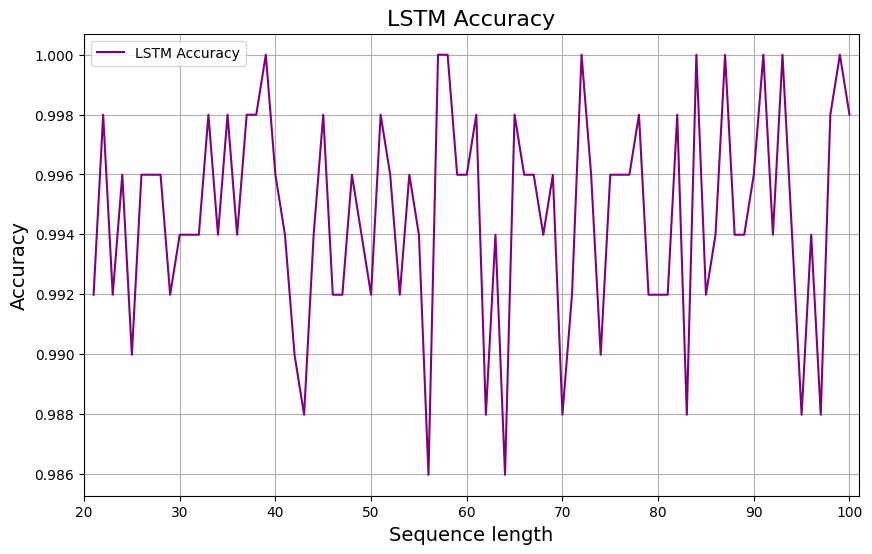

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.xlim(20, 101)
plt.xlabel('Sequence length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('LSTM Accuracy', fontsize=16)
plt.legend()
plt.grid(True)
#plt.show()

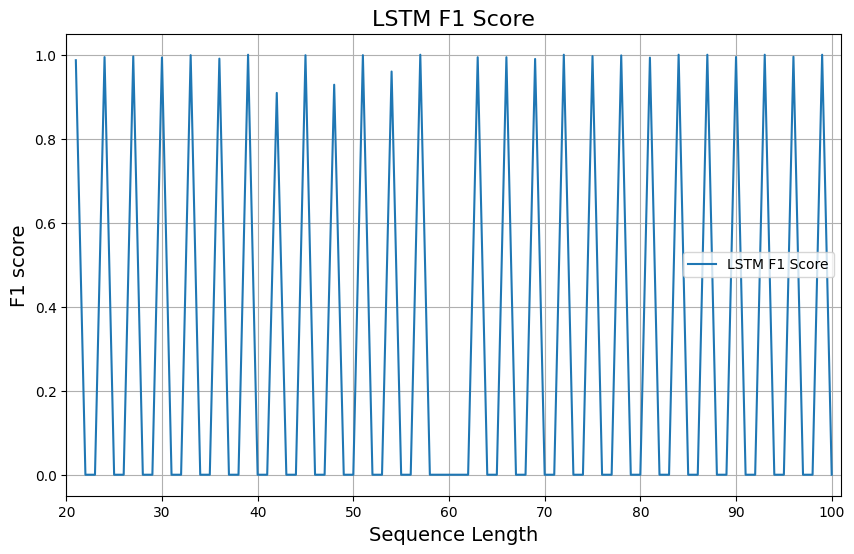

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.title('LSTM F1 Score', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Plot results from both models

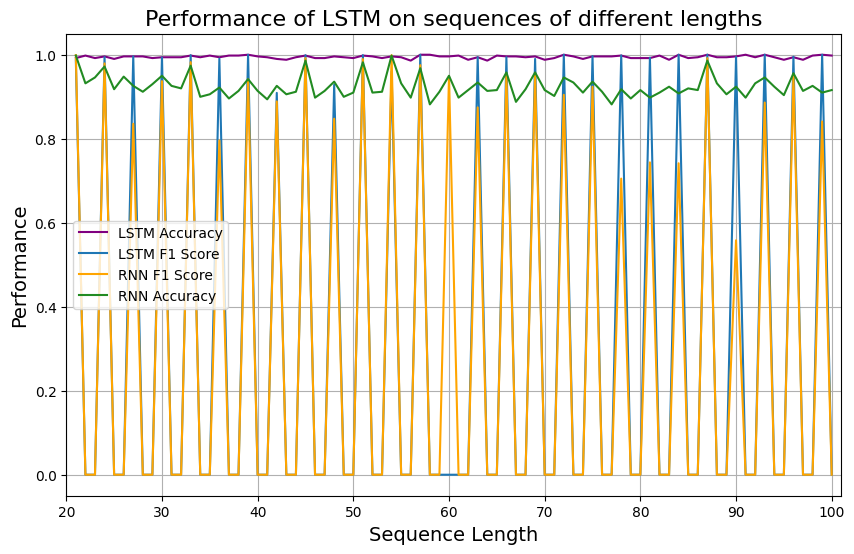

In [26]:
# Load vanilla RNN
rnn_accuracy_per_length = np.loadtxt('RNN_acc.csv', delimiter=',')
rnn_f1_score_per_length = np.loadtxt('RNN_f1.csv', delimiter=',')

plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score')
plt.plot(range(21, 101), rnn_f1_score_per_length, label='RNN F1 Score', color='orange')
plt.plot(range(21, 101), rnn_accuracy_per_length, label='RNN Accuracy', color='forestgreen')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## F1-score - both models

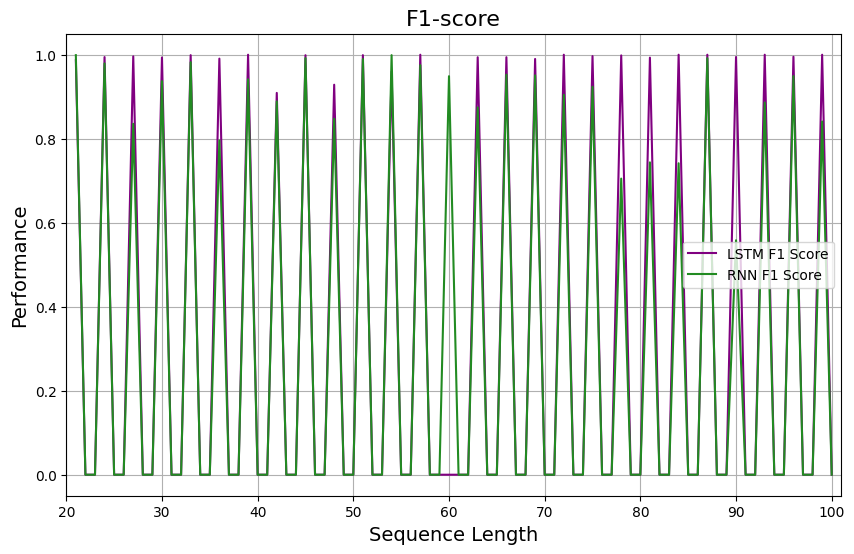

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score', color='purple')
plt.plot(range(21, 101), rnn_f1_score_per_length, label='RNN F1 Score', color='forestgreen')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.title('F1-score', fontsize=16)
plt.legend()
plt.grid(True)
plt.savefig('f1score.png')
plt.show()

## Accuracy - both models

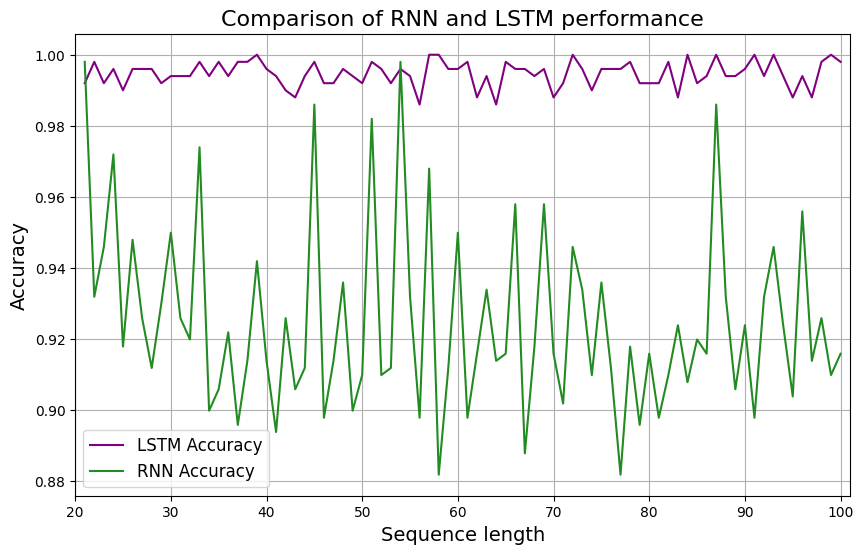

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.plot(range(21, 101), rnn_accuracy_per_length, label='RNN Accuracy', color='forestgreen')
plt.xlim(20, 101)
plt.xlabel('Sequence length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of RNN and LSTM performance', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('accuracy.png')
plt.show()

In [31]:
np.average(accuracy_per_length), np.average(rnn_accuracy_per_length), np.average(f1_score_per_length), np.average(rnn_f1_score_per_length)

(0.9946643286573146,
 0.9247244488977955,
 0.3213988397538185,
 0.3016805504380862)